# Image Classifier Prototype

In [1]:
from fashion_image_classifier.feature_extraction import FeatureExtractor
from glob import glob
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
import seaborn as sns
import math

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

## Loading Images

In [2]:
not_worn_paths = glob("../workdir/training_images/not-worn/image_*.png")
worn_paths = glob("../workdir/training_images/worn/image_*.png")
print(f"Negative Training Samples: {len(not_worn_paths)}")
print(f"Positive Training Samples: {len(worn_paths)}")

Negative Training Samples: 97
Positive Training Samples: 309


In [3]:
extractor = FeatureExtractor()
X_negative = extractor.extract_features(images_paths=not_worn_paths)
y_negative = np.array([0] * X_negative.shape[0])
X_positive = extractor.extract_features(images_paths=worn_paths)
y_positive = np.array([1] * X_positive.shape[0])

In [4]:
X = np.vstack([X_negative, X_positive])
y = np.hstack([y_negative, y_positive])

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (406, 196608)
Shape of y: (406,)


## Step 0: Cluster Visualization

100%|██████████| 10/10 [06:12<00:00, 37.23s/it]


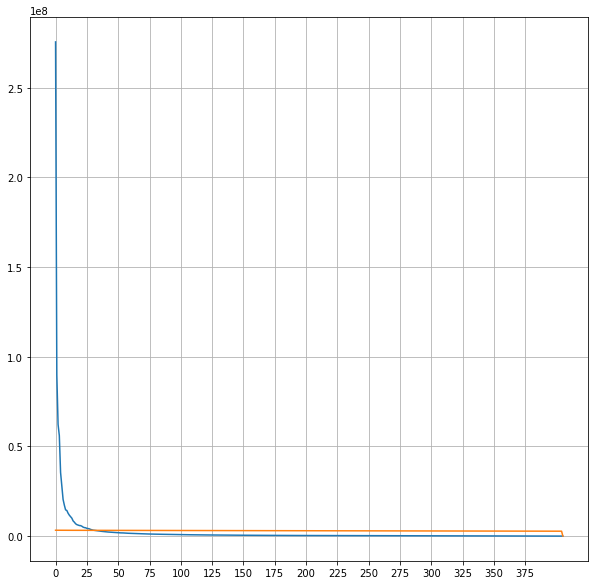

In [6]:
def find_pcs(data, permutations=30):
    noise_variance_matrix = []
    for _ in tqdm(range(permutations), total=permutations):
        noise = data.flatten()
        np.random.shuffle(noise)
        noise = noise.reshape(data.shape)
        noise_variance_vector = PCA().fit(noise).explained_variance_
        noise_variance_matrix.append(noise_variance_vector)
        
    actual_variance_vector = PCA().fit(data).explained_variance_
    mean_noise_variance_vector = np.mean(np.vstack(noise_variance_matrix), axis=0)
    
    return actual_variance_vector, mean_noise_variance_vector

actual_var, noise_var = find_pcs(X, permutations=10)

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(actual_var)
ax.plot(noise_var)
ax.set_xticks(ticks=range(0, 400, 25))
ax.grid()

plt.show()

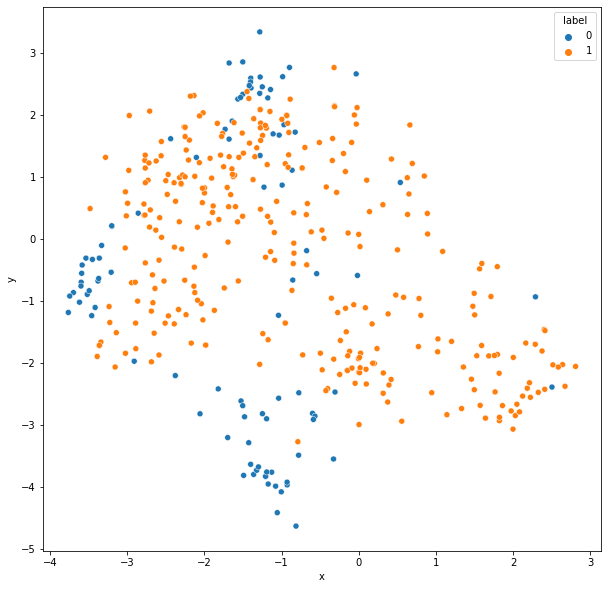

In [8]:
diff = actual_var - noise_var

feature_space = PCA(n_components=(actual_var - noise_var).tolist().index(next(filter(lambda value: value < 0, diff)))).fit_transform(X)

feature_projection = TSNE(n_components=2, perplexity=X.shape[0]/2, n_iter=1000).fit_transform(feature_space)
feature_projection = pd.DataFrame({"x": feature_projection[:, 0], "y": feature_projection[:, 1], "label": y})

fig, ax = plt.subplots(figsize=(10, 10))

_ = sns.scatterplot(x="x", y='y', data=feature_projection, hue="label", ax=ax)

## Step 1: Naive Classifier

In [9]:
y_mean = np.mean(y)
y_naive = [y_mean] * y.shape[0]

print(f"Naive Accuracy: {accuracy_score(y, np.round(y_naive))}")
print(f"Naive Log-Loss: {log_loss(y, y_naive)}")

Naive Accuracy: 0.7610837438423645
Naive Log-Loss: 0.5498274958671725


## Step 2: Simple (no HPT) Logit Classifier

In [10]:
splitter = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

metric_results = []

for train_index, test_index in tqdm(splitter.split(X, y), total=50, desc="Repeated Fitting"):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    logit = SGDClassifier(loss="log", max_iter=5_000, random_state=42069)
    logit.fit(X_train, y_train)
    y_hat = logit.predict_proba(X_train)[:, 1]
    y_hat_test = logit.predict_proba(X_test)[:, 1]
    
    metrics = {
        "train_accuracy": accuracy_score(y_train, np.round(y_hat)),
        "test_accuracy": accuracy_score(y_test, np.round(y_hat_test)),
        "train_loss": log_loss(y_train, y_hat),
        "test_loss": log_loss(y_test, y_hat_test),
    }
    metric_results.append(metrics)

Repeated Fitting: 100%|██████████| 50/50 [03:11<00:00,  3.83s/it]


### Evaluation

,train_accuracy,test_accuracy,train_loss,test_loss
count,50.000000,50.000000,50.000000,50.000000
mean,0.942591,0.887256,1.982848,3.894073
std,0.082817,0.076766,2.860411,2.651419
min,0.479452,0.560976,0.189254,0.842409
25%,0.926761,0.853659,0.662392,2.527252
50%,0.969863,0.902439,1.040908,3.369656
75%,0.980822,0.926829,2.529642,5.054484
max,0.994521,0.975610,17.979089,15.163365


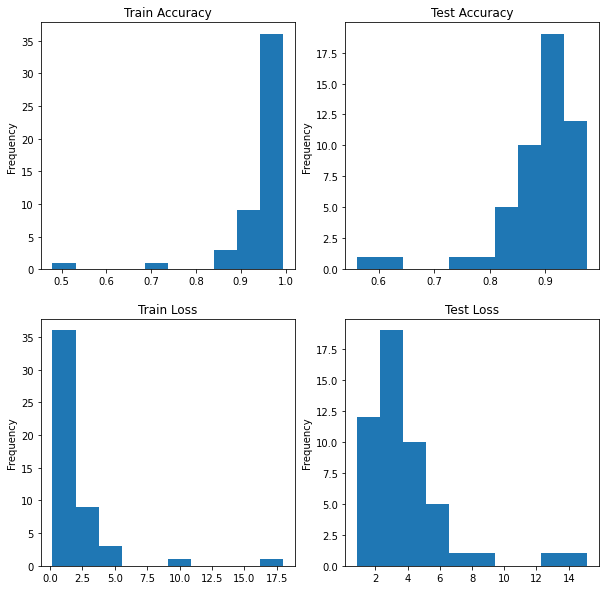

In [11]:
metrics = pd.DataFrame(metric_results)

display(metrics.describe())


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = metrics.train_accuracy.plot(kind="hist", ax=ax[0][0], title="Train Accuracy")
_ = metrics.test_accuracy.plot(kind="hist", ax=ax[0][1], title="Test Accuracy")
_ = metrics.train_loss.plot(kind="hist", ax=ax[1][0], title="Train Loss")
_ = metrics.test_loss.plot(kind="hist", ax=ax[1][1], title="Test Loss")

## Step 2b: Complex Logit Classifier

In [ ]:
param_bounds = {
    "use_scaler": (0, 1),
    "use_pca": (0, 1),
    "pca__kernel": (0, (3-1e-10)),
    "pca__n_components": (2, 400),
    "pca__gamma": (0, 1),
    "classifier__alpha": (1e-4, 1)
}

kernel_dict = {
    0: "linear",
    1: "rbf",
    2: "cosine"
}

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

def logit_fit_function(use_scaler, use_pca, pca__kernel, pca__n_components, pca__rbf_gamma, classifier__alpha):
    splitter = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
    
    pipeline = logit_pipeline = Pipeline([
        ("scaler", StandardScaler() if use_scaler >= 0.5 else "passthrough"),
        ("pca", KernelPCA(n_components=round(pca__n_components), kernel=kernel_dict[math.floor(pca__kernel)], gamma=pca__rbf_gamma)
if use_pca >= 0.5 else "passthrough"),
        ("classifier", SGDClassifier(loss='log', max_iter=5_000, random_state=42069, alpha=classifier__alpha))
    ])
    
    for train_index, val_index in splitter.split(X_train, y_train):
        X_train_sub, X_val, y_train_sub, y_val = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
        
        _ = pipeline.fit(X_train_sub, y_train_sub)
        y_hat = pipeline.predict_proba(X_val)
        
        val_loss = -log_loss(y_val, y_hat)
        
    return val_loss

    
optimizer = BayesianOptimization(
    f=logit_fit_function,
    pbounds=param_bounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=3,
    n_iter=15
)

In [37]:
optimizer.max

{'target': -0.2553755054464055,
 'params': {'classifier__alpha': 0.004716732301232256,
  'pca__kernel': 2.463039601727721,
  'pca__n_components': 205.95603782617852,
  'pca__rbf_gamma': 0.536676330160721,
  'use_pca': 0.7383971777491775,
  'use_scaler': 0.9452567575757278}}

In [12]:
logit_optimal_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", KernelPCA(kernel="cosine", n_components=206)),
    ("classifier", SGDClassifier(loss='log', max_iter=5_000, random_state=42069, alpha=0.004716732301232256))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

_ = logit_optimal_pipeline.fit(X_train, y_train)

y_hat = logit_optimal_pipeline.predict_proba(X_test)[:, 1]

print(f"Best Test Accuracy: {accuracy_score(y_test, np.round(y_hat))}")
print(f"Best Test Log Loss: {log_loss(y_test, y_hat)}")

Best Test Accuracy: 0.926829268292683
Best Test Log Loss: 0.26026440694390957


## Step 3: SVC

In [ ]:
svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", KernelPCA()),
    ("classifier", SVC())
])

param_bounds = {
    "use_scaler": (0, 1),
    "use_pca": (0, 1),
    "pca__kernel": (0, (3-1e-10)),
    "pca__n_components": (2, 400),
    "pca__rbf_gamma": (0, 1),
    "classifier__C": (1e-4, 10),
    "classifier__kernel": (0, (3 - 1e-10)),
    "classifier__gamma": (-2, 2),
}

kernel_dict = {
    0: "linear",
    1: "rbf",
    2: "cosine"
}

def parse_gamma(gamma):
    if gamma <= -1:
        return "auto"
    elif gamma <= 0:
        return "scale"
    else:
        return gamma

def logit_fit_function(use_scaler, use_pca, pca__kernel, pca__n_components, pca__rbf_gamma, classifier__C, classifier__kernel, classifier__gamma):
    splitter = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
    
    pipeline =  Pipeline([
        ("scaler", StandardScaler() if use_scaler >= 0.5 else "passthrough"),
        ("pca", KernelPCA(n_components=round(pca__n_components), kernel=kernel_dict[math.floor(pca__kernel)], gamma=pca__rbf_gamma)
if use_pca >= 0.5 else "passthrough"),
        ("classifier", SVC(probability=True, C=classifier__C, gamma=parse_gamma(classifier__gamma), kernel=kernel_dict[math.floor(classifier__kernel)]))
    ])
    
    for train_index, val_index in splitter.split(X, y):
        X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
        
        _ = pipeline.fit(X_train, y_train)
        y_hat = pipeline.predict_proba(X_val)
        
        val_loss = -log_loss(y_val, y_hat)
        
    return val_loss

logger = JSONLogger(path="./svc_hpt_log.json")
optimizer = BayesianOptimization(
    f=logit_fit_function,
    pbounds=param_bounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    init_points=3,
    n_iter=15
)

## Step 4: Neural Network